In [13]:
from types import MethodType
from cirkit.symbolic.circuit import Circuit
from cirkit.symbolic.layers import GaussianLayer, SumLayer

def build_circuit_one_sum(
    self,
    *,
    input_factory,        # like lambda scope, n: GaussianLayer(scope, n)
    sum_weight_factory,   # your ParameterFactory for the SumLayer
    num_input_units: int, # # of outputs per Gaussian leaf
    num_sum_units: int,   # # of mixtures in the one SumLayer
) -> Circuit:
    # 1) Find all the leaves in the region graph:
    leaves = [node for node in self.topological_ordering()
              if not self.region_inputs(node)]
    
    layers = []
    in_layers = {}
    
    # 2) Build one GaussianLayer per leaf
    gaussians = []
    for leaf in leaves:
        gauss = input_factory(leaf.scope, num_input_units)
        layers.append(gauss)
        gaussians.append(gauss)
    
    # 3) Build *one* SumLayer mixing them all
    sum_layer = SumLayer(
        num_input_units=num_input_units,
        num_output_units=num_sum_units,
        arity=len(gaussians),
        weight_factory=sum_weight_factory,
    )
    layers.append(sum_layer)
    in_layers[sum_layer] = gaussians
    
    # 4) Return a circuit whose only output is that top‐sum
    print(layers,"---------------\n\n\n",in_layers,"---------------\n\n\n",[sum_layer])
    return Circuit(layers, in_layers, outputs=[sum_layer])


In [14]:
import functools
from types import MethodType
from cirkit.templates.region_graph import RandomBinaryTree
from cirkit.templates.utils import Parameterization, parameterization_to_factory
from cirkit.symbolic.parameters import mixing_weight_factory

def define_circuit_one_sum(
    num_input_units: int = 3,
    num_sum_units:   int = 2,
) -> Circuit:
    # ── 1) Build the region‐graph (just to get leaf scopes) ────────────
    rg = RandomBinaryTree(1, depth=None, num_repetitions=1, seed=42)
    
    # ── 2) Attach our star‐builder ────────────────────────────────────
    rg.build_circuit = MethodType(build_circuit_one_sum, rg)
    
    # ── 3) Make the factories ─────────────────────────────────────────
    input_factory = lambda scope, n: GaussianLayer(scope=scope, num_output_units=n)
    p = Parameterization(activation="softmax", initialization="normal")
    sum_param_factory = parameterization_to_factory(p)
    # (we don’t need an n‐ary mixing factory here, just the base factory)
    
    # ── 4) Build & return ─────────────────────────────────────────────
    return rg.build_circuit(
        input_factory=input_factory,
        sum_weight_factory=sum_param_factory,
        num_input_units=num_input_units,
        num_sum_units=num_sum_units,
    )


[GaussianLayer(scope=Scope({0}), num_output_units=100, config=(scope=Scope({0}), num_output_units=100)params=(mean=Parameter(shape=(100,)), stddev=Parameter(shape=(100,)))), SumLayer(num_input_units=100, num_output_units=100, arity=1, config=(num_input_units=100, num_output_units=100, arity=1), params=(weight=Parameter(shape=(100, 100)))] ---------------


 {SumLayer(num_input_units=100, num_output_units=100, arity=1, config=(num_input_units=100, num_output_units=100, arity=1), params=(weight=Parameter(shape=(100, 100))): [GaussianLayer(scope=Scope({0}), num_output_units=100, config=(scope=Scope({0}), num_output_units=100)params=(mean=Parameter(shape=(100,)), stddev=Parameter(shape=(100,))))]} ---------------


 [SumLayer(num_input_units=100, num_output_units=100, arity=1, config=(num_input_units=100, num_output_units=100, arity=1), params=(weight=Parameter(shape=(100, 100)))]
Structural properties:
  - Smoothness: True
  - Decomposability: True
  - Structured-decomposability: True
Tor

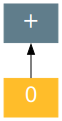

In [15]:
# tweak these as you like:
NUM_INPUT_UNITS = 100 # e.g. 4 Gaussians per leaf
NUM_SUM_UNITS   = 100   # e.g. 5 mixture components in the single SumLayer

net = define_circuit_one_sum(NUM_INPUT_UNITS, NUM_SUM_UNITS)

from cirkit.pipeline import PipelineContext
ctx = PipelineContext(backend="torch", semiring="sum-product", fold=False, optimize=False)
cc  = ctx.compile(net).cpu().eval()
# Print which structural properties the circuit satisfies
print(f'Structural properties:')
print(f'  - Smoothness: {net.is_smooth}')
print(f'  - Decomposability: {net.is_decomposable}')
print(f'  - Structured-decomposability: {net.is_structured_decomposable}')
print(cc)
from cirkit.symbolic.io import plot_circuit
if plot_circuit is not None:
    dot = plot_circuit(net, orientation="vertical")
    display(dot)

In [16]:
import torch
from torch.distributions import Normal

# --- assume cc is your TorchCircuit instance ---
# e.g. cc = TorchCircuit(...)

# 1) Prepare inputs
input_vals = torch.tensor([[0.5], [1.0], [0.3]])  # shape (batch=3, vars=1)

# 2) Run the circuit
net_out = cc(input_vals)  # shape (3, 100)
net_out = net_out.squeeze(1) 
# 3) Extract the GaussianLayer and compute per-component PDFs
gi = cc.layers[0]  # TorchGaussianLayer

# raw parameters for mu and sigma
mu_node      = gi.mean._nodes[0]._ptensor            # shape (1, 200)
raw_sigma    = gi.stddev._nodes[0]._ptensor          # shape (1, 200)
sigma        = gi.stddev._nodes[1].forward(raw_sigma)# after sigmoid, shape (1, 200)

# expand to batch-size
# mu & sigma: (1,200) -> (3,200)
mu_exp   = mu_node.expand(input_vals.size(0), -1)
sigma_exp= sigma.expand(input_vals.size(0), -1)

# now compute each PDF for each output-unit i
# input_vals[:,0] is shape (3,), unsqueeze to (3,1) to broadcast against (3,200)
x = input_vals[:, 0].unsqueeze(1)  # (3,1)
normal = Normal(mu_exp, sigma_exp)
g_manual = normal.log_prob(x).exp()  # (3,200)

# 4) Extract the SumLayer weights and normalize
sl = cc.layers[1]  # TorchSumLayer
raw_w   = sl.weight._nodes[0]._ptensor       # shape (1,100,200)
w_norm  = sl.weight._nodes[1].forward(raw_w) # softmaxed along last dim, shape (1,100,200)
w_norm  = w_norm.squeeze(0)                  # (100,200)

# 5) Manually do the weighted sum: for each sample b and each output-unit j
#    y_manual[b,j] = sum_i g_manual[b,i] * w_norm[j,i]
#    g_manual: (3,200) -> (3,1,200), w_norm: (100,200) -> (1,100,200)
y_manual = (g_manual.unsqueeze(1) * w_norm.unsqueeze(0)).sum(-1)  # (3,100)
print(net_out.shape,y_manual.shape)
# print(net_out,y_manual)
# 6) Assert they match
assert torch.allclose(net_out, y_manual, atol=1e-6), "Mismatch between network and manual!"
print("✅ Manual calculation matches the circuit output.")


torch.Size([3, 100]) torch.Size([3, 100])
✅ Manual calculation matches the circuit output.


TorchCircuit(
  (0): TorchGaussianLayer(
    folds: 1  variables: 1  output-units: 10000
    input-shape: (1, 1, -1, 1)
    output-shape: (1, -1, 10000)
    (mean): TorchParameter(
      shape: (1, 10000)
      (0): TorchPointerParameter(
        output-shape: (1, 100)
        (_parameter): TorchTensorParameter(output-shape: (1, 100))
      )
      (1): TorchPointerParameter(
        output-shape: (1, 100)
        (_parameter): TorchTensorParameter(output-shape: (1, 100))
      )
      (2): TorchPointerParameter(
        output-shape: (1, 100)
        (_parameter): TorchTensorParameter(output-shape: (1, 100))
      )
      (3): TorchPointerParameter(
        output-shape: (1, 100)
        (_parameter): TorchTensorParameter(output-shape: (1, 100))
      )
      (4): TorchScaledSigmoidParameter(
        input-shapes: [(1, 100)]
        output-shape: (1, 100)
      )
      (5): TorchScaledSigmoidParameter(
        input-shapes: [(1, 100)]
        output-shape: (1, 100)
      )
      (6): 

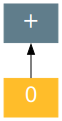

In [18]:
import cirkit.symbolic.functional as SF

# Construct the circuit computing Z, i.e., the integral of |c(X)|^2 over the complete domain of X
symbolic_circuit_partition_func = SF.multiply(net, net)
print(symbolic_circuit_partition_func)
print(ctx.compile(symbolic_circuit_partition_func))
plot_circuit(symbolic_circuit_partition_func)